In [116]:
%%latex

$$\textbf{A brief summary of what has been done}$$
$$\\$$

$\mathbf{1.}$ In the beginning we construct ISM transmition function which depends on $z$ and $\lambda$ (not redshifted).
In the code below it is named $$\textit{F_IMS}$$

$$\\$$

$\mathbf{2.}$ In the next cell we choose a filter to work with (in our case it is f160w) and build its 
transmition function $$\textit{F_filter}$$

$$\\$$

$\mathbf{3.}$ Inside the following cell we face for the first time the source data for the fake hst image simulation and 
thereafter extract and derived from it another important quantities such as masses, times, metallicities and current
redshift. It is worth to mention that we specified a spherical region (25 kpc) with the highest mass density 
at the center in lieu of working with the full box.

$$\\$$

$\mathbf{4.}$ Next there are two functions for convenience. To understand what they stand for see its description.

$$\\$$

$\mathbf{5.}$ Now we enter the main simulation process. First, let's break down simple but important calculations here:

$$\\$$

5.1 The angular size of our specified region is
\begin{equation}
\theta \thinspace [milli-arcsec] = \frac{2 \times R \thinspace  [kpc]}{D_{a} [Mpc]} \times (radians \thinspace to \thinspace milli-arcsec
                                                                  \thinspace coef)
= \frac{2 \times 25 \thinspace  [pc] \times 10^{3}}{D_{a} [pc] \times 10^{6}} \times 206265 \times 10^{3},
\end{equation}
where $D_{a}$ - angular distance, $2R$ - diameter of the sphere

$$\\$$

5.2 Then we want milli-arcsecond/pixel = 60/1 ratio. Therefore, number of pixels along each axis is simply $nbins = 
\theta \thinspace [milli-arcsec] / 60$

$$\\$$

$\mathbf{6.}$ The next step is to work with fluxes. Let's consider an arbitrary pixel in our mesh. 
$$\\$$

6.1 Initially, from look-up tables
we have SED in [ (Solar luminosity units) / (Solar mass units) / Hz ] for specific time, metallicity and wavelength
$$\\$$
6.2 Then from our source data we know the amount of mass concentrated in the pixel. So we multiply SED by this
amount of mass $m$[in solar mass units].
$$\\$$
6.3 Because these calculations for a specific $\lambda$ and $z$ we can also multiply ($SED \times m$) by transmition 
function throughout the ISM (F_IMS).

6.4 Now we can compute total flux:
\begin{equation}
\mathbf{F} \thinspace \left[ \thinspace \frac{erg}{s \thinspace cm{2}} \thinspace \right]
\thinspace =  \thinspace \frac{ \int\limits_{0}^{+\infty} L_{\nu} \times F_{filter} \times L_{\odot} d\nu}{4\pi D_{L}^{2}}, \quad
\text{where} \thinspace L_{\odot} = 3.828 \times 10^{33}, \thinspace L_{\nu} = SED \times m \times F_{ISM}
\thinspace [\thinspace (Solar  \thinspace luminosity  \thinspace units) \thinspace /  \thinspace Hz \thinspace ]
\end{equation} 
and $D_{L}$ is the luminosity distance [Mpc].

$$\\$$

$\mathbf{7.}$ Finally, only two things left to do. We should add noize to our image and then convolve it with Point 
spread function for f160w filter.

$$\\$$
7.1 We get noise data from another image. Therefore, before adding the noise to our image we need to make sure
that the units of two term in the sum are the same. Actually, it turns out, that there are not. Thus, let's convert 
Flux $\mathbf{F}$.
$$\\$$
Noise data zero point = 25.94. 
$$\\$$
$\mathbf{F}$ in $\thinspace \left[ \thinspace \frac{erg}{s \thinspace cm{2}} \thinspace \right]
$ corresponds to zero point = -48.6.
$$\\$$
\begin{equation}
\kappa \thinspace \thinspace (from \thinspace \mathbf{F} \thinspace to \thinspace noise) \thinspace = \thinspace 10^{0.4(25.94 + 48.6)} = 6.5464 \times 10^{29}
\end{equation}
$$\\$$
\begin{equation}
\mathbf{\tilde{F}} = \mathbf{F} \times \kappa + noise \thinspace \thinspace  data
\end{equation}





<IPython.core.display.Latex object>

In [1]:
%matplotlib notebook

import yt
import glob
import numpy              as np
import healpy             as hp
import cosmolopy          as cp
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import scipy.ndimage      as ndimage

from scipy                import signal
from scipy.interpolate    import interp1d
from scipy.interpolate    import interp2d
from scipy.interpolate    import RegularGridInterpolator
from scipy                import integrate
from astropy.io           import fits
from astropy              import wcs
from mpl_toolkits.mplot3d import Axes3D


<IPython.core.display.Javascript object>


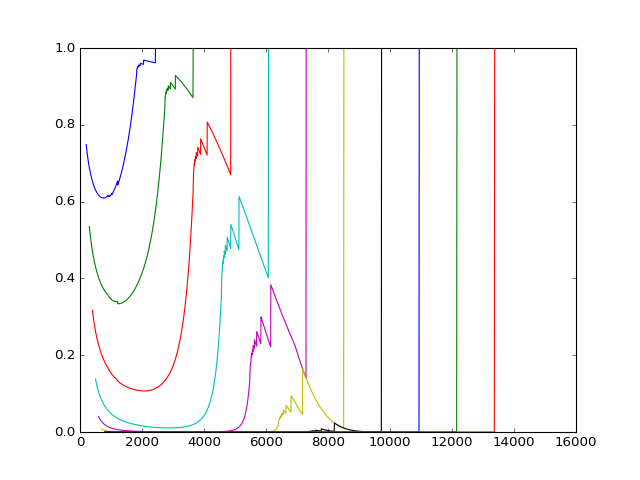

In [2]:
'''

Transmition function throughout the ISM, which depends on redshift z and radiation wavelength

'''

table = np.loadtxt('table_transmition_ISM.dat')
lam_rest   = table[1:,0]
z          = table[0,1:]
trans_coef = table[1:,1:]

F_IMS = interp2d(z, lam_rest, trans_coef)

plt.figure(0)
for i in range(1,11):
    plt.plot(lam_rest*(1+i),F_IMS(i,lam_rest))

    

In [4]:
'''

To get the filter of interest (f160w), its transmition function, the lowest and the highest wavelength

'''

filters_info = []
for line in open('data/FILTER.RES.latest.info', 'r'):
    filters_info.append(np.array(line.split()))
filters_info = np.array(filters_info)

temp_filters = open('data/FILTER.RES.latest', 'r')
filters = []
filters_names = []
first = True

for line in temp_filters:

    if line[0] == ' ':
        if not first:
            filters.append(np.array(temp))

        first = False
        filters_names.append(line.split())
        temp = []

    else:
        temp.append(np.array(line.split()).astype('float'))

filters.append(np.array(temp))
filters = np.array(filters)

for ifilt in range(len(filters_names)):
    if filters_names[ifilt][1] == 'hst/wfc3/IR/f160w.dat':
        filter_b = np.array([filters[ifilt][:,1],filters[ifilt][:,2]])
        filter_b = np.transpose(filter_b)

F_filter = interp1d(filter_b[:,0], filter_b[:,1],fill_value=0.0)
left,right = np.min(filter_b[:,0]),np.max(filter_b[:,0])

yt : [WARNING  ] 2016-08-18 01:01:52,618 DeltaDC != 0, which implies auni != abox.  Be sure you understand which expansion parameter is appropriate for your use! (Gnedin, Kravtsov, & Rudd 2011)
yt : [INFO     ] 2016-08-18 01:01:52,638 Parameters: current_time              = 909401005.0300856 yr
yt : [INFO     ] 2016-08-18 01:01:52,639 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2016-08-18 01:01:52,640 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2016-08-18 01:01:52,641 Parameters: domain_right_edge         = [ 32.  32.  32.]
yt : [INFO     ] 2016-08-18 01:01:52,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2016-08-18 01:01:52,643 Parameters: current_redshift          = 6.124184822106263
yt : [INFO     ] 2016-08-18 01:01:52,644 Parameters: omega_lambda              = 0.6964000165462494
yt : [INFO     ] 2016-08-18 01:01:52,645 Parameters: omega_matter              = 0.3035999834537506
yt : [INFO     ] 2016-08-18 01:01:

{}


yt : [INFO     ] 2016-08-18 01:01:56,165 Loading field plugins.
yt : [INFO     ] 2016-08-18 01:01:56,167 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-08-18 01:01:56,169 Loaded astro (15 new fields)
yt : [INFO     ] 2016-08-18 01:01:56,170 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-08-18 01:01:56,171 Loaded fluid (63 new fields)
yt : [INFO     ] 2016-08-18 01:01:56,174 Loaded fluid_vector (95 new fields)
yt : [INFO     ] 2016-08-18 01:01:56,175 Loaded geometric (111 new fields)
yt : [INFO     ] 2016-08-18 01:01:56,176 Loaded local (111 new fields)
yt : [INFO     ] 2016-08-18 01:01:56,177 Loaded magnetic_field (119 new fields)
yt : [INFO     ] 2016-08-18 01:01:56,178 Loaded my_plugins (119 new fields)
yt : [INFO     ] 2016-08-18 01:01:56,179 Loaded species (121 new fields)
yt : [INFO     ] 2016-08-18 01:01:58,611 Created 8 chunks for ARTIO


<IPython.core.display.Javascript object>


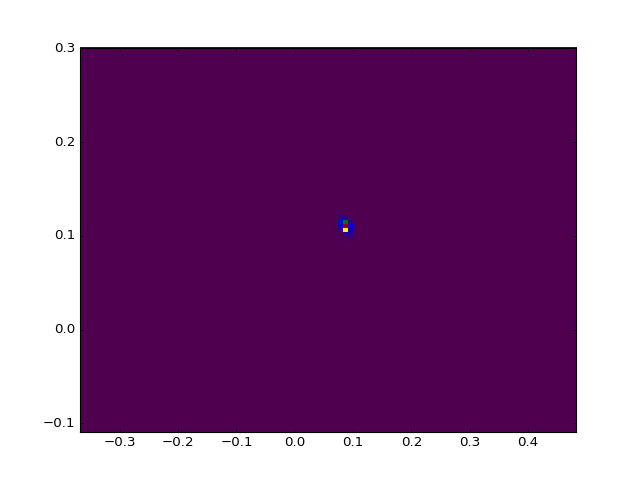

(array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 array([-0.36839966, -0.35988967, -0.35137968, -0.34286969, -0.3343597 ,
        -0.32584971, -0.31733972, -0.30882973, -0.30031974, -0.29180975,
        -0.28329976, -0.27478977, -0.26627978, -0.2577698 , -0.24925981,
        -0.24074982, -0.23223983, -0.22372984, -0.21521985, -0.20670986,
        -0.19819987, -0.18968988, -0.18117989, -0.1726699 , -0.16415991,
        -0.15564992, -0.14713994, -0.13862995, -0.13011996, -0.12160997,
        -0.11309998, -0.10458999, -0.09608   , -0.08757001, -0.07906002,
        -0.07055003, -0.06204004, -0.05353005, -0.04502006, -0.03651008,
        -0.02800009, -0.0194901 , -0.01098011, -0.00247012,  0.00603987,
         0.01454986,  0.02305985,  0.03156984,  0.0400798

In [5]:
'''

To load and thereafter calculate all the necessary data for simulation

'''

sun_lumi = 3.828e33 # [erg/s]
sun_mass = 1.989e33 # [g]
secinrad = 206265.0

muf_list = glob.glob("./drt/muv.bin*")             # Solar lumi/ Hz / Solar mass (log10 time in yr, metallicity, lambda) tables
files = glob.glob("./rei05B_a0*/rei05B_a*.art")    # 3D HST Data
pf = yt.load(files[0])

lam_list = np.zeros(len(muf_list))
lookup = np.zeros([len(muf_list), 188, 22])

for i in range(len(muf_list)):

    f = open(muf_list[i])
    header = f.readline()
    f.close()
    d1 = header.split()[0]
    d2 = header.split()[1]
    lam_list[i] = float(header.split()[2])

    data = np.genfromtxt(muf_list[i], skip_header=1)
    lookup[i, :, :] = data[1:,1:]

dx = data[0, 1:] # metallicity in Solar metal. units
dy = data[1:, 0] # log10 time in yr

# to specify a region of interest in the sky
data = pf.sphere('c', (25.0, "kpc"))

x = np.array(data[('STAR', 'POSITION_X')] - data.center[0])
y = np.array(data[('STAR', 'POSITION_Y')] - data.center[1])
z = np.array(data[('STAR', 'POSITION_Z')] - data.center[2])

m = data[('STAR', 'MASS')].in_units('g')/sun_mass
met = data[('STAR', 'METALLICITY_SNIa')] + data[('STAR', 'METALLICITY_SNII')]
t = np.log10(data[('STAR', 'age')].in_units('yr'))
redshift = pf.current_redshift
lam_list *= (1+redshift) # to get redshifted lam

plt.figure(1)
plt.hist2d(x,y,100)

In [10]:
def pixel_integration(pixel,lam):

    '''

     To integrate each pixel over all the lambdas with f160w filter transmition function (F_filter)

     pixel: 3d array, (pixel SED(lambdas) 2d map, lambdas) [x direction, y direction, lambdas],
     units [erg/s/Hz/Solar_luminosity]

     lam: 1d array, containing lambdas to integrate over, redshifted,
     units [angstrom]

     mtr_int: matrix, total flux from the object at redshift z in each pixel,
     units [erg/s/cm^2]

    '''
    
    sun_lumi = 3.828e33
    c = 2.99792458e10
    nu = c/(lam/1e8)

    mtr_int = np.zeros_like(pixel[:,:,0])

    for i in range(0,len(pixel[:,0,0])):
        for j in range(0,len(pixel[0,:,0])):

            mtr_int[i,j] = integrate.trapz( pixel[i,j,::-1] * sun_lumi * F_filter(lam[::-1]), nu[::-1])\
                           / (4 * np.pi * np.power(lum_dist*3.0857e18*1e6,2)) /   integrate.trapz(F_filter(lam[::-1]), nu[::-1])

    return mtr_int

In [11]:
def filter_range(a,b,x): # x - array, a,b - number (boundaries)
    
    global lambdas

    '''

    Initially we have SED tables for vast range of wavelengths and this function picks out those wavelengths, which
    are in filter range (for our current purposes it is f160w).

    '''

    position_in_lam_array = []
    lambdas               = []

    for i in range(0,len(x)):
        if (a<=x[i] and x[i]<=b):
            
            if(F_filter(x[i]) >= 1e-3):
                
                position_in_lam_array.append(i)
                lambdas.append(x[i])

    lambdas = np.array(lambdas)
    position_in_lam_array = np.array(position_in_lam_array)

    indices = np.argsort(lambdas)

    return position_in_lam_array[indices]

number of pixels 143


<IPython.core.display.Javascript object>


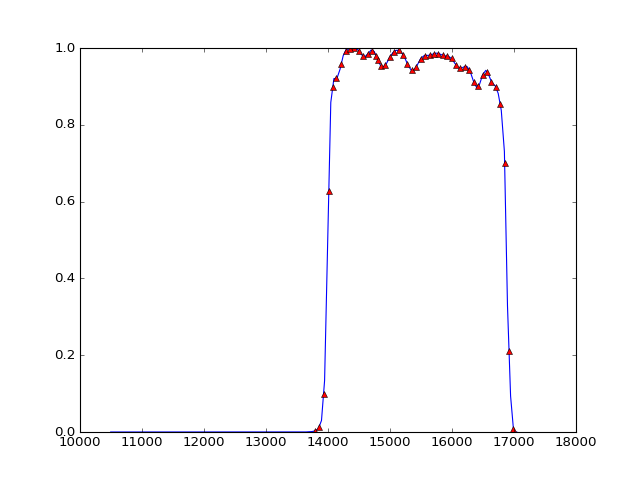

In [12]:
'''

The main procedure to create a fake HST image

nbins: number of pixels in our image (both for x axix and y axix [z axis])

ang_dist: angular distance
units [Mpc]

lum_dist: luminosity distance
units [Mpc]

filter_lam: lambdas, which are in the filter range
units [Angstoms]

theta_milliarcsec: selected region as it is seen by HST
units [milli-arcseconds]

We define the following resolution for the fake image: 60 milli-arcsecond/pixel

'''


ang_dist = cp.distance.angular_diameter_distance(redshift, **cp.fidcosmo)
lum_dist = ang_dist * (1+redshift) * (1+redshift)

theta_milliarcsec = ( 2 * 25.0 * 1e3 ) / ( ang_dist * 1e6  ) * ( secinrad * 1e3 )
nbins =  int(theta_milliarcsec * 1/60)

print('number of pixels', nbins)

filter_lam = filter_range(left,right,lam_list)

plt.figure(2)
plt.plot(filter_b[:,0],F_filter(filter_b[:,0]),'b-')
plt.plot(lambdas,F_filter(lambdas),'r^')




233 13785.2976308 1935.0 1.0
12 13856.539479 1945.0 1.0
557 13927.7813272 1955.0 1.0
163 14013.2715451 1967.0 1.0
248 14077.3892085 1976.0 1.0
503 14134.3826871 1984.0 1.0
386 14212.7487201 1995.0 1.0
403 14283.9905683 2005.0 1.0
462 14355.2324165 2015.0 1.0
356 14426.4742648 2025.0 1.0
166 14497.716113 2035.0 1.0
102 14568.9579612 2045.0 1.0
358 14640.1998094 2055.0 1.0
510 14711.4416576 2065.0 1.0
372 14775.559321 2074.0 1.0
474 14804.0560603 2078.0 1.0
15 14853.9253541 2085.0 1.0
41 14925.1672023 2095.0 1.0
228 14996.4090505 2105.0 1.0
548 15067.6508988 2115.0 1.0
346 15138.892747 2125.0 1.0
486 15210.1345952 2135.0 1.0
243 15281.3764434 2145.0 1.0
485 15352.6182916 2155.0 1.0
529 15423.8601399 2165.0 1.0
138 15495.1019881 2175.0 1.0
537 15566.3438363 2185.0 1.0
107 15637.5856845 2195.0 1.0
186 15708.8275327 2205.0 1.0
27 15780.069381 2215.0 1.0
96 15851.3112292 2225.0 1.0
101 15922.5530774 2235.0 1.0
431 15993.7949256 2245.0 1.0
199 16065.0367738 2255.0 1.0
331 16136.2786221 2265.0

<IPython.core.display.Javascript object>


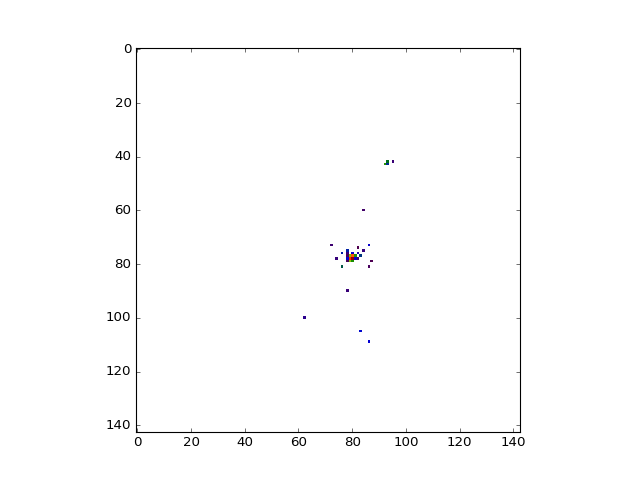

/home/maryhallow/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10


In [13]:
image = np.zeros([nbins, nbins, 3, len(filter_lam)])
image_int = np.zeros([nbins, nbins, 3, 0])

index = 0

for i in filter_lam:

    print(i,lam_list[i],lam_list[i]/(1+redshift),F_IMS(redshift,lam_list[i]/(1+redshift))[0])

    interp = interp2d(dx, dy, lookup[i, :, :])
    temp = m.copy()

    for j in range(len(m)):
        temp[j] *= F_IMS(redshift,lam_list[i]/(1+redshift))[0]*interp(met[j], t[j])[0]  # [erg/s/Hz] in Solar luminosity

    xedges = np.linspace(-data.radius, data.radius, nbins+1)
    yedges = np.linspace(-data.radius, data.radius, nbins+1)

    H, X, Y = np.histogram2d(x, y, bins=(xedges, yedges), weights = temp)
    image[:, :, 0, index] = H

    index += 1

image_int = pixel_integration(image[:,:,0,:],lam_list[filter_lam])

plt.figure(3)
plt.imshow(np.log10(image_int), interpolation='nearest')

CTYPE1  ='RA---TAN'                                                              [astropy.io.fits.card]
CTYPE2  ='DEC--TAN'                                                              [astropy.io.fits.card]
DATE-OBS='2009-12-13'                                                            [astropy.io.fits.card]
TIME-OBS='21:23:07'                                                              [astropy.io.fits.card]
ROOTNAME='ibcj03kdq                                                              [astropy.io.fits.card]
TARGNAME='OMEGACEN                                                               [astropy.io.fits.card]
FILTER1 =                                                                        [astropy.io.fits.card]
FILTER2 =                                                                        [astropy.io.fits.card]


<IPython.core.display.Javascript object>


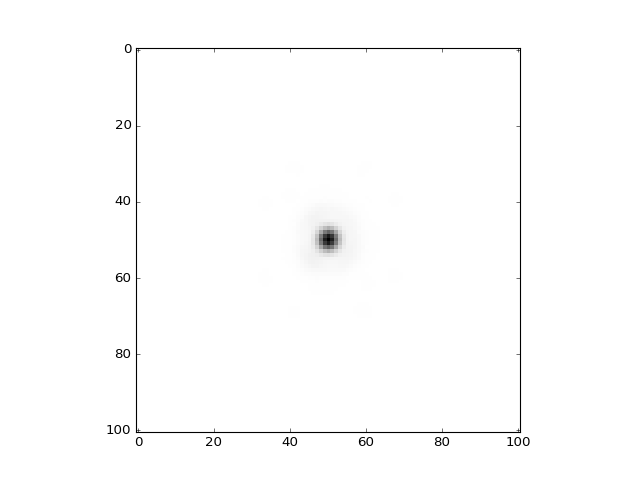

<IPython.core.display.Javascript object>


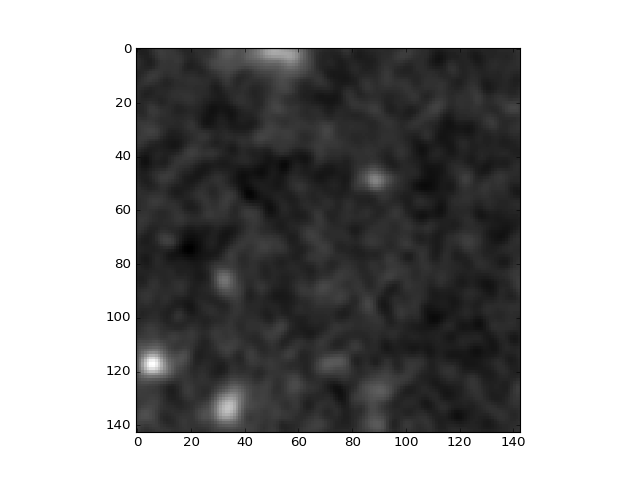

In [14]:
'''

Point spread function (from WFC3 PSFs)
(check out http://www.stsci.edu/hst/wfc3/analysis/PSF for more information)

Noise (from HLS GOODS-S region)
(check out https://archive.stsci.edu/prepds/hlf/ for more information)

It is also important to convect our simulation data and noise data into the same units (by using AB magnitudes)

image_int: (energy flux density for each pixel without noise and PSF)
units [erg/s/cm^2]

'''

pixels_with_noise = fits.open('hlsp_hlf_hst_wfc3-60mas_goodss_f160w_v1.0_sci.fits')[0].data[10650:10650+nbins,12600:12600+nbins]
zero_point = 25.94
coeff = 10 ** (0.4 * (zero_point + 48.6) )

image_int *= coeff
image_int += pixels_with_noise


PSF = fits.open('psf_wfc3ir_f160w.fits')[0].data
plt.figure(4)
plt.imshow(PSF, interpolation='nearest',cmap=cm.Greys)
blurred = signal.fftconvolve(image_int, PSF, mode='same')

np.savetxt('f160w_filter.dat',blurred,fmt='%1.5e')

plt.figure(5)
plt.imshow(blurred, interpolation='nearest',cmap=plt.cm.gray)
plt.show()

<IPython.core.display.Javascript object>


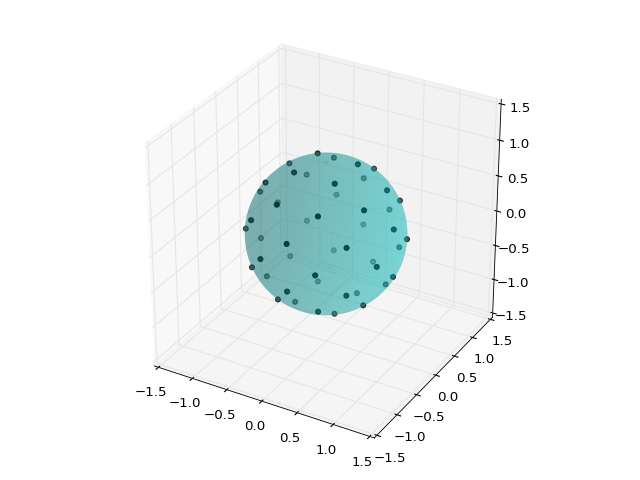

In [5]:
'''
evenly distributed points on a sphere

'''

fig = plt.figure(6)
ax = fig.add_subplot(111, projection='3d')

# Create a sphere
phi, theta = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]

x = np.sin(phi)*np.cos(theta)
y = np.sin(phi)*np.sin(theta)
z = np.cos(phi)

ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

# Create points
NSIDE = 2   # Number of pixels = 12 * 2**NSIDE
a = hp.nside2npix(NSIDE)
theta,phi = hp.pix2ang(NSIDE,np.arange(a))
pix_vec   = hp.pix2vec(NSIDE,np.arange(a))

points = np.zeros((len(theta),3))
points[:,0] = np.sin(theta)*np.cos(phi)
points[:,1] = np.sin(theta)*np.sin(phi)
points[:,2] = np.cos(theta)

ax.scatter(points[:,0], points[:,1], points[:,2],c='k')
ax.set_aspect("equal")
plt.tight_layout()